Emotion Chatbot

In [1]:
! pip install datasets

In [2]:
!pip install emoji --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.3 MB/s eta 0:00:00


In [3]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [4]:
!pip install --upgrade datasets

In [5]:
pip install -U sentence-transformers

In [6]:
import emoji
import re
import pandas as pd
import numpy as np
import os
import torch
import wandb
import ast
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from datasets import Dataset
from sklearn.metrics.pairwise import cosine_similarity



def remove_emoji(text) :
  return emoji.replace_emoji(text, replace='')

In [7]:
import nltk

# Download the stopwords corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [10]:
def clean_text(text) :
   text = text.lower()
   text =remove_emoji(text)
   text = re.sub(r'http\S+|www\S+|https\S+', '', text)
   text = re.sub(r'[^\w\s]', '', text)
   text = re.sub(r'@\w+', '', text)
   text = re.sub(r'\s+', ' ', text).strip()
   text = re.sub(r'\d+', '', text)

   tokens = [w for w in text.split() if w not in stop_words]
   text = " ".join(tokens)
   text = lemmatize_text(text)
   tokens = [w for w in text.split() if 2 <= len(w) <= 20]
   text = " ".join(tokens)
   return text

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from google.colab import files
uploaded = files.upload()

Saving DailyDialog Archive.zip to DailyDialog Archive.zip


In [15]:
!unzip -q DailyDialog.zip

In [16]:
df= pd.read_csv("/content/train.csv")

In [17]:
df.head()

,dialog,act,emotion
0,"['Say , Jim , how about going for a few beers ...",[3 4 2 2 2 3 4 1 3 4],[0 0 0 0 0 0 4 4 4 4]
1,"['Can you do push-ups ? '\n "" Of course I can ...",[2 1 2 2 1 1],[0 0 6 0 0 0]
2,"['Can you study with the radio on ? '\n ' No ,...",[2 1 2 1 1],[0 0 0 0 0]
3,['Are you all right ? '\n ' I will be all righ...,[2 1 1 1],[0 0 0 0]
4,"['Hey John , nice skates . Are they new ? '\n ...",[2 1 2 1 1 2 1 3 4],[0 0 0 0 0 6 0 6 0]


In [18]:
df["clean_text"] =df["dialog"].apply(clean_text)

In [19]:
texts= df["clean_text"].to_list()


In [20]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

In [21]:
vectorizer.get_feature_names_out()

array(['abby', 'abc', 'ability', ..., 'zone', 'zoo', 'zu'], dtype=object)

In [22]:
print(X.shape)

(11118, 5000)


In [23]:
kmeans = KMeans(n_clusters=50, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [24]:
df['cluster']

,cluster
0,3
1,2
2,42
3,12
4,3
...,...
11113,19
11114,14
11115,2
11116,28


In [25]:
inertia = []
K = range(2, 100)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)



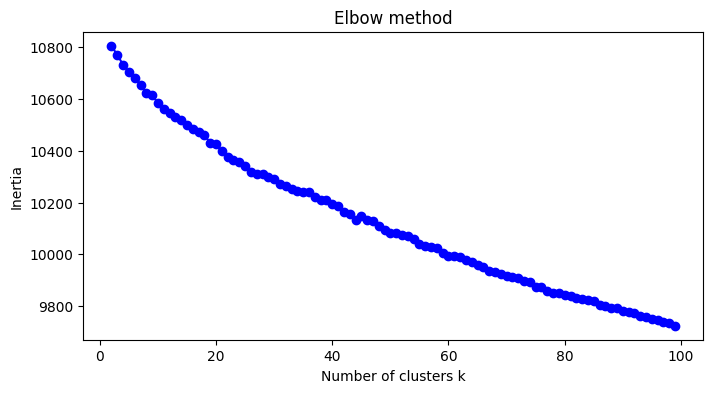

In [26]:
plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

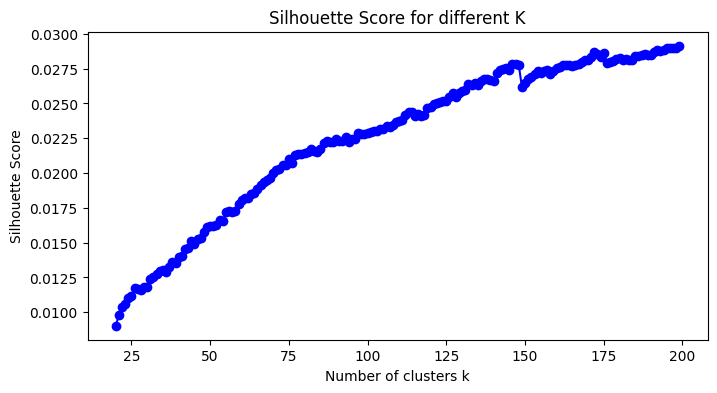

In [27]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range( 20,200)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(8,4))
plt.plot(K, sil_scores, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different K')
plt.show()

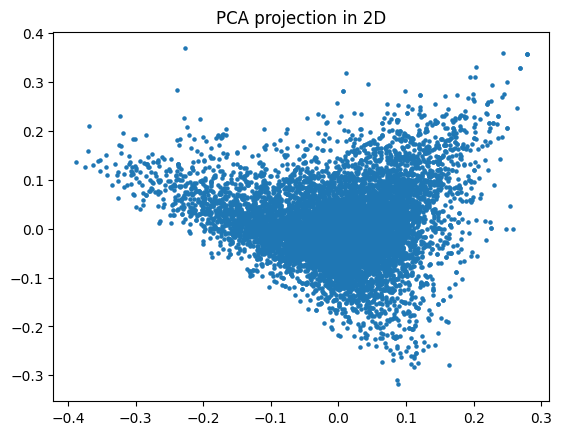

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], s=5)
plt.title("PCA projection in 2D")
plt.show()

In [29]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X_counts = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_counts)

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Sujet {idx}: {', '.join(top_terms)}")

Sujet 0: yeah, day, good, love, look, oh, time, like, know, think
Sujet 1: want, look, car, house, yes, people, know, think, play, like
Sujet 2: help, good, use, account, money, yes, know, like, want, need
Sujet 3: new, day, company, thank, like, good, time, yes, job, work
Sujet 4: leave, let, know, oh, time, look, thank, yes, right, bus
Sujet 5: let, ill, thank, think, buy, good, yes, look, want, like
Sujet 6: yes, school, movie, food, chinese, think, know, english, good, like
Sujet 7: country, year, know, product, people, business, price, good, think, company
Sujet 8: pay, help, right, like, check, ok, thank, yes, sir, room
Sujet 9: oh, tomorrow, right, time, ill, come, sorry, mr, yes, thank


In [30]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(texts)

nmf = NMF(n_components=10, random_state=42)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(H):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Sujet {idx}: {', '.join(top_terms)}")

Sujet 0: coffee, order, good, sound, drink, kind, yes, movie, food, like
Sujet 1: problem, dollar, cash, help, money, pay, account, card, check, need
Sujet 2: business, new, hard, office, position, experience, year, company, job, work
Sujet 3: nice, ill, tomorrow, hello, morning, good, time, mr, come, thank
Sujet 4: feel, day, thing, tell, ve, oh, yeah, time, think, know
Sujet 5: right, check, double, yes, night, hotel, number, single, reservation, room
Sujet 6: station, street, long, train, right, walk, minute, excuse, stop, bus
Sujet 7: want, help, price, try, yes, new, car, buy, let, look
Sujet 8: flight, reservation, afraid, ticket, order, excuse, table, yes, sorry, sir
Sujet 9: yes, good, language, teacher, learn, study, class, school, speak, english


In [31]:
model_s= SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model_s.encode(texts)
print(embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(11118, 384)


In [32]:
similarities = cosine_similarity(embeddings)
print(similarities)

[[ 1.0000001   0.35245717  0.05686551 ...  0.13184945  0.07887498
   0.07033252]
 [ 0.35245717  1.0000002   0.03446003 ...  0.12724715  0.01782574
   0.07785542]
 [ 0.05686551  0.03446003  1.         ... -0.02120398  0.08277523
   0.13710515]
 ...
 [ 0.13184945  0.12724715 -0.02120398 ...  0.9999999   0.09379789
   0.10249665]
 [ 0.07887498  0.01782574  0.08277523 ...  0.09379789  0.9999999
   0.15647785]
 [ 0.07033252  0.07785542  0.13710515 ...  0.10249665  0.15647785
   1.0000002 ]]


In [36]:
dataset = load_dataset("go_emotions")

print(dataset['train'][0])

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [37]:
print(dataset['train'].features)

# Labels
print(dataset['train'].features['labels'].feature.names)

{'text': Value('string'), 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'id': Value('string')}
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [38]:
harmonized_labels = ["joy", "anger", "sadness", "love", "fear", "surprise", "neutral"]
label_to_id = {label: i for i, label in enumerate(harmonized_labels)}

# --- 2. Mapping GoEmotions → harmonisé
mapping = {
    "admiration": "joy",
    "amusement": "joy",
    "excitement": "joy",
    "joy": "joy",
    "approval": "joy",
    "pride": "joy",

    "anger": "anger",
    "annoyance": "anger",
    "disgust": "anger",

    "sadness": "sadness",
    "grief": "sadness",
    "disappointment": "sadness",
    "remorse": "sadness",
    "embarrassment": "sadness",

    "love": "love",
    "caring": "love",
    "gratitude": "love",

    "fear": "fear",
    "nervousness": "fear",
    "worry": "fear",

    "surprise": "surprise",
    "neutral": "neutral",

    "confusion": "neutral",
    "curiosity": "neutral",
    "realization": "neutral",
    "relief": "neutral",
    "optimism": "neutral",
}


In [39]:
goemotions_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                     'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
                     'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
                     'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
                     'sadness', 'surprise', 'neutral']


In [41]:
def harmonize_labels(label_indices):
    mapped = []
    for idx in label_indices:
        if idx < len(goemotions_labels):
            original_label = goemotions_labels[idx]
            if original_label in mapping:
                mapped.append(mapping[original_label])
    return list(set(mapped))

def preprocess_labels(example):
    vector = [0] * len(harmonized_labels)
    for lbl in harmonize_labels(example["labels"]):
        if lbl in label_to_id:
            vector[label_to_id[lbl]] = 1
    example["labels"] = [float(x) for x in vector]
    return example



# --- 5. Application sur toutes les splits
dataset = dataset.map(preprocess_labels)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [42]:
for i in range(10):
    print(dataset["train"][i]["labels"])


[0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1]


In [43]:
lengths = set(len(x["labels"]) for x in dataset["train"])
print("Tailles uniques trouvées :", lengths)

Tailles uniques trouvées : {7}


In [44]:
train_data = dataset['train']
test_data = dataset['test']
valid_data = dataset['validation']

In [45]:
def add_clean_text(example):
    example['text_clean'] = clean_text(example['text'])
    return example

In [46]:
train_data = train_data.map(add_clean_text, num_proc=4, desc="Cleaning text")

Cleaning text (num_proc=4):   0%|          | 0/43410 [00:00<?, ? examples/s]

In [47]:
def add_text_hash(example):
    example["text_hash"] = hash(example["text_clean"])
    return example

train_data = train_data.map(add_text_hash, num_proc=4)

Map (num_proc=4):   0%|          | 0/43410 [00:00<?, ? examples/s]

In [48]:
seen_hashes = set()
def is_unique(example):
    text_hash = example["text_hash"]
    if text_hash in seen_hashes:
        return False
    seen_hashes.add(text_hash)
    return True

train_data_nodup = train_data.filter(is_unique, desc="Removing duplicates")

print(f"Before cleaning: {len(train_data)}")
print(f"After cleaning : {len(train_data_nodup)}")


Removing duplicates:   0%|          | 0/43410 [00:00<?, ? examples/s]

Avant nettoyage : 43410
Après nettoyage et suppression doublons : 41185



"prajjwal1/bert-tiny"
"Varnikasiva/sentiment-classification-bert-mini"



In [68]:
tokenizer = AutoTokenizer.from_pretrained( "distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
   "distilbert-base-uncased",
    num_labels=7,
    ignore_mismatched_sizes=True ,
    problem_type="multi_label_classification"
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
dataset_hf = train_data_nodup


# Apply tokenizer on HF dataset
def tokenize_fn(batch):
    return tokenizer(batch['text_clean'], truncation=True, padding=False,
        max_length=512,
        return_tensors=None)

dataset_hf = dataset_hf.map(tokenize_fn, batched=True, num_proc=4, desc="Tokenizing")


Tokenizing (num_proc=4):   0%|          | 0/41185 [00:00<?, ? examples/s]

In [70]:
dataset_hf

Dataset({
    features: ['text', 'labels', 'id', 'text_clean', 'text_hash', 'input_ids', 'attention_mask'],
    num_rows: 41185
})

In [71]:
def compute_metrics(p):
    predictions = torch.sigmoid(torch.tensor(p.predictions))
    preds = (predictions >= 0.5).int().numpy()
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {"accuracy": acc, "weighted_f1": f1}

In [72]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    logging_strategy="steps",
    logging_steps=50
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [73]:
def has_labels(example):
    return len(example["labels"]) > 0

dataset_hf = dataset_hf.filter(has_labels)


Filter:   0%|          | 0/41185 [00:00<?, ? examples/s]

In [74]:
def has_labels(example):
    return len(example["labels"]) > 0

dataset_validation = dataset["validation"].map(add_clean_text, num_proc=4)
dataset_validation = dataset_validation.filter(has_labels)

In [75]:
dataset_valid_hf = dataset_validation

# Tokenize validation
dataset_valid_hf = dataset_valid_hf.map(tokenize_fn, batched=True, num_proc=4, desc="Tokenizing validation")


Tokenizing validation (num_proc=4):   0%|          | 0/5426 [00:00<?, ? examples/s]

In [76]:


class DataCollatorWithFloatLabels(DataCollatorWithPadding):
    def __call__(self, features):
        labels = []
        for feature in features:
            label = feature.pop("labels")
            if isinstance(label, torch.Tensor):
                labels.append(label.detach().clone().float())
            else:
                labels.append(torch.tensor(label, dtype=torch.float))

        batch = super().__call__(features)
        batch['labels'] = torch.stack(labels)
        return batch


In [77]:


data_collator = DataCollatorWithFloatLabels(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_hf,
    eval_dataset=dataset_valid_hf,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [78]:
print(dataset_hf[0]['labels'])  # doit être une liste de longueur 7
print(dataset_valid_hf[0]['labels'])


[0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1]


In [79]:
def has_positive_label(example):
    return any(l == 1 for l in example["labels"])

dataset_hf = dataset_hf.filter(has_positive_label)
dataset_valid_hf = dataset_valid_hf.filter(has_positive_label)


Filter:   0%|          | 0/41185 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [80]:
print([ex["labels"] for ex in dataset_hf.shuffle(seed=42).select(range(5))])


[[1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0]]


In [81]:
os.environ["WANDB_DISABLED"] = "true"

In [82]:
wandb.init(mode="disabled")

In [83]:


def convert_labels_to_tensor(example):
    example["labels"] = torch.tensor(example["labels"], dtype=torch.float)
    return example

dataset_hf = dataset_hf.map(convert_labels_to_tensor)
dataset_valid_hf = dataset_valid_hf.map(convert_labels_to_tensor)


Map:   0%|          | 0/39451 [00:00<?, ? examples/s]

Map:   0%|          | 0/5162 [00:00<?, ? examples/s]

In [84]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Weighted F1
1,0.239800,0.222977,0.583303,0.669323
2,0.209300,0.222433,0.582381,0.676993
3,0.153300,0.244621,0.590490,0.679829


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=7725, training_loss=0.20432033489437165, metrics={'train_runtime': 12319.7089, 'train_samples_per_second': 10.029, 'train_steps_per_second': 0.627, 'total_flos': 513228342688374.0, 'train_loss': 0.20432033489437165, 'epoch': 3.0})

In [85]:
trainer.save_model("./mon-modele2-finetuned")

In [86]:
label_names = ["joy", "sadness", "anger", "fear", "love", "surprise", "neutral"]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


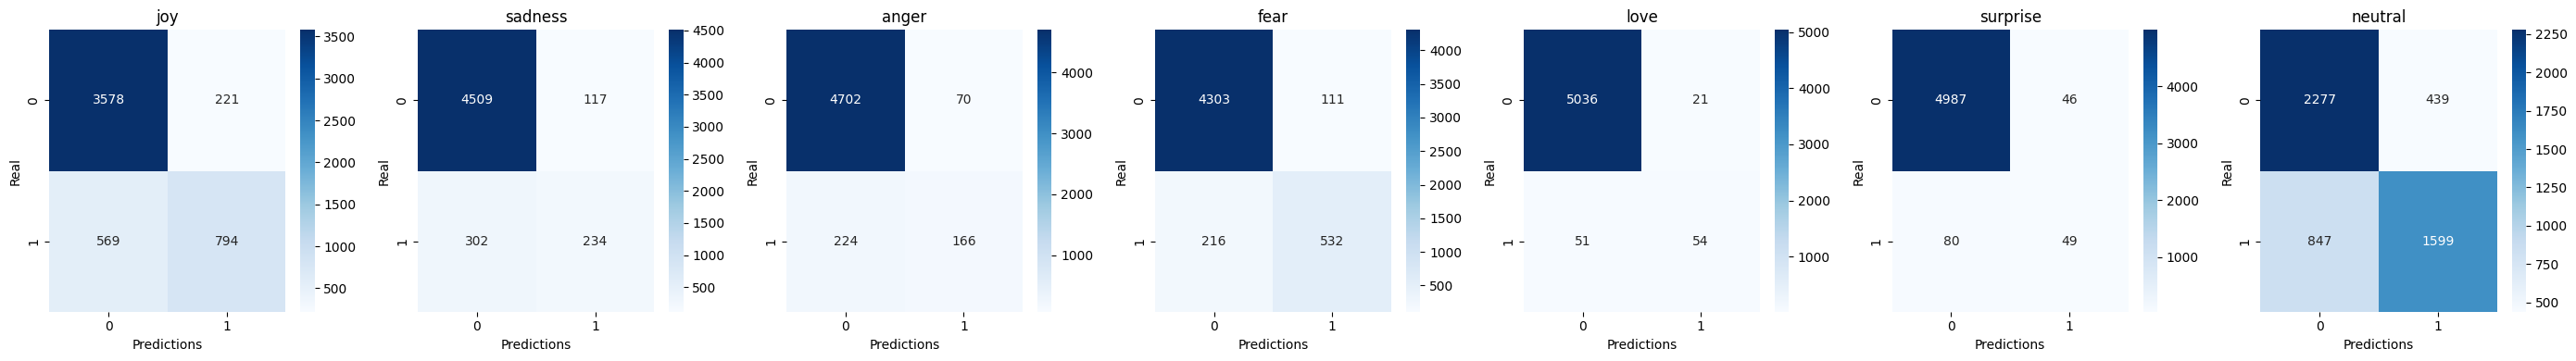

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

preds = trainer.predict(dataset_valid_hf)
y_true = preds.label_ids
y_prob = preds.predictions
y_pred = (y_prob >= 0.5).astype(int)


mcm = multilabel_confusion_matrix(y_true, y_pred)


def plot_multilabel_confusion(mcm, label_names):
    n_labels = len(label_names)
    fig, axes = plt.subplots(1, n_labels, figsize=(4*n_labels, 4))

    if n_labels == 1:
        axes = [axes]

    for i, (cm, label) in enumerate(zip(mcm, label_names)):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(label)
        axes[i].set_xlabel("Predictions")
        axes[i].set_ylabel("Real")
        axes[i].set_xticklabels(["0", "1"])
        axes[i].set_yticklabels(["0", "1"])

    plt.tight_layout()
    plt.show()


plot_multilabel_confusion(mcm, label_names)


In [88]:
id2label = {
    0: "joy",
    1: "sadness",
    2: "anger",
    3: "fear",
    4: "love",
    5: "surprise",
    6: "neutral"
}

In [89]:
import torch
import numpy as np
from torch.nn import Sigmoid


harmonized_labels = ["joy", "anger", "sadness", "love", "fear", "surprise", "neutral"]


id2label = {i: label for i, label in enumerate(harmonized_labels)}


THRESHOLD = 0.3





In [161]:
def predict_emotion(text, model, tokenizer, threshold=THRESHOLD, device='cpu'):
   model.eval()
   model.to(device)
   # Tokenizer
   inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
   inputs = {k:v.to(device) for k,v in inputs.items()}

   with torch.no_grad():
      outputs = model(**inputs)
      logits = outputs.logits

   probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    # Map id → label
   emotions = {id2label[i]: float(probs[i]) for i in range(len(probs))}

    # prediction >= to the threshold
   predicted_labels = [label for label, score in emotions.items() if score >= threshold]

    # classification
   top_label = max(emotions, key=emotions.get)

   return emotions, predicted_labels, top_label

In [91]:
problem_keywords = {
    "jealous": "jealousy",
    "insecure": "jealousy",
    "trust": "trust",
    "faithful": "trust",
    "far": "distance",
    "distant": "distance",
    "misunderstand": "misunderstanding",
    "confused": "misunderstanding",
    "over": "moving_on",
    "move on": "moving_on"
}

Created Dataset

In [92]:
utterances = [
  {"speaker":"A","text":"I get jealous when they hang out with certain friends. It makes me insecure.","emotion":"fear","problem":"jealousy"},
  {"speaker":"B","text":"I feel sad that they don’t trust me even though I’ve never lied.","emotion":"sadness","problem":"trust"},
  {"speaker":"A","text":"Being long-distance is so hard, I miss them constantly.","emotion":"sadness","problem":"distance"},
  {"speaker":"B","text":"It’s frustrating when they misinterpret what I mean, we argue for no reason.","emotion":"anger","problem":"misunderstanding"},
  {"speaker":"A","text":"Seeing them move on after our breakup really hurts.","emotion":"sadness","problem":"moving_on"},
{"speaker":"B","text":"I fear they will like someone else while we sort things out.",
"emotion":"fear",
"problem":"jealousy"},
  {"speaker":"A","text":"They don't tell me anything personal, and it makes me sad.",
"emotion":"sadness",
"problem":"trust"},
  {"speaker":"B","text":"When we disagree on small things, I get so angry.",
"emotion":"anger",
"problem":"misunderstanding"},
  {"speaker":"A","text":"I resent the distance between us; I just want to see them.",
"emotion":"sadness",
"problem":"distance"},
  {"speaker":"B","text":"Seeing them happy with someone else saddens me inside.",
"emotion":"sadness",
"problem":"moving_on"},
{"speaker":"A","text":"I get jealous when they talk of past relationships.",
"emotion":"fear",
"problem":"jealousy"},
  {"speaker":"B","text":"I'm angry they don't believe me when I say I'm honest.",
"emotion":"sadness",
"problem":"trust"},
  {"speaker":"A","text":"Long distance is making me sad and lonely.",
"emotion":"sadness",
"problem":"distance"},
  {"speaker":"B","text":"I get really angry when they play with my words and misjudge me.",
"emotion":"anger",
"problem":"misunderstanding"},
  {"speaker":"A","text":"It hurts me to think they're moving on faster than me.",
"emotion":"sadness",
"problem":"moving_on"},
{"speaker":"B","text":"I feel jealous that they seem closer to other people than to me.","emotion":"fear","problem":"jealousy"},
  {"speaker":"A","text":"It hurts that they doubt me even though I’ve done nothing wrong.","emotion":"sadness","problem":"trust"},
  {"speaker":"B","text":"I’m tired of miscommunications causing fights every week.","emotion":"anger","problem":"misunderstanding"},
  {"speaker":"A","text":"The distance makes every day feel heavier than it should.","emotion":"sadness","problem":"distance"},
  {"speaker":"B","text":"Seeing them happy without me triggers a mix of sadness and jealousy.","emotion":"sadness","problem":"moving_on"},
{"speaker":"A","text":"I can't help but be jealous when they flirt online.",
"emotion":"fear",
"problem":"jealousy"},
  {"speaker":"B","text":"It makes me angry that they suspect me of lying always.",
"emotion":"anger",
"problem":"trust"},
  {"speaker":"A","text":"I'm lonely being so distant, I just yearn for closeness.",
"emotion":"sadness",
"problem":"distance"},
  {"speaker":"B","text":"Any minor misunderstanding escalates to a quarrel in minutes and I get angry.",
"emotion":"anger",
"problem":"misunderstanding"},
  {"speaker":"A","text":"It pains me to see them move on and enjoy themselves without me.",
"emotion":"sadness",
"problem":"moving_on"},
  {"speaker":"B","text":"I'm apprehensive when they compliment someone else.","emotion":"fear","problem":"jealousy"},
{"speaker":"A","text":"It's hard when they don't trust my decisions, even little ones.",
"emotion":"sadness","problem":"trust"},
  {"speaker":"B","text":"Arguments start with little misunderstandings and I just get annoyed.",
"emotion":"anger","problem":"misunderstanding"},
  {"speaker":"A","text":"Distance is so draining, I just want us to be together.",
"emotion":"sadness","problem":"distance"},
  {"speaker":"B","text":"Seeing them move on is painful to my heart.",
"emotion":"sadness","problem":"moving_on"},
  {"speaker":"A","text":"I feel jealous when they get attention from other people.",
"emotion":"fear","problem":"jealousy"},
  {"speaker":"B","text":"It's annoying when they don't trust my intentions.",
"emotion":"sadness","problem":"trust"},
{"speaker":"A","text":"Being away all the time makes me lonely and empty.",
"emotion":"sadness",
"problem":"distance"},
  {"speaker":"B","text":"Misunderstandings only keep piling up and I end up getting angry.",
"emotion":"anger",
"problem":"misunderstanding"},
  {"speaker":"A","text":"I dislike the thought that they would move on from me.",
"emotion":"sadness",
"problem":"moving_on"},
  {"speaker":"B","text":"I feel jealous when they look happier with their friends than with me.",
"emotion":"fear",
"problem":"jealousy"},
  {"speaker":"A","text":"It's painful when they don't believe in my word.",
"emotion":"sadness",
"problem":"trust"},
  {"speaker":"B","text":"Small misunderstandings escalate into huge fights, it's exhausting.",
"emotion":"anger",
"problem":"misunderstanding"},
{"speaker":"A","text":"Long distance is crappy; I just want them near.",
"emotion":"sadness",
"problem":"distance"},
  {"speaker":"B","text":"Seeing them move on and on kills me inside.",
"emotion":"sadness",
"problem":"moving_on"},
  {"speaker":"A","text":"I get nervous when they notice others.","emotion":"fear","problem":"jealousy"},
  {"speaker":"B","text":"It's infuriating when they don't trust me for no reason.","emotion":"anger","problem":"trust"},
  {"speaker":"A","text":"Being this far from each other makes everyday tougher than it has to be.","emotion":"sadness","problem":"distance"},
  {"speaker":"B","text":"Misunderstandings always arise and it pisses me off.","emotion":"anger","problem":"misunderstanding"},
{"speaker":"A","text":"I feel sad thinking about them moving on without me.","emotion":"sadness","problem":"moving_on"},
  {"speaker":"B","text":"Jealousy hits me whenever they talk to someone else.","emotion":"fear","problem":"jealousy"},
  {"speaker":"A","text":"It’s hurtful when they don’t trust me on even small things.","emotion":"sadness","problem":"trust"},
  {"speaker":"B","text":"Miscommunications always leave me feeling angry and drained.","emotion":"anger","problem":"misunderstanding"},
  {"speaker":"A","text":"Distance makes me feel like I’m missing a part of my life.","emotion":"sadness","problem":"distance"},
  {"speaker":"B","text":"I feel sadness seeing them happy without me.","emotion":"sadness","problem":"moving_on"}
]


In [93]:
import random

positive_utterances = [
    {"speaker":"A","text":"I feel happy when they compliment me sincerely.","problem":"trust", "emotion":"joy"},
    {"speaker":"B","text":"Spending time together always lifts my mood.","problem":"moving_on", "emotion":"love"},
    {"speaker":"A","text":"I love it when we understand each other without words.","problem":"misunderstanding", "emotion":"love"},
    {"speaker":"B","text":"Seeing them smile makes my day so much better.","problem":"trust", "emotion":"joy"},
    {"speaker":"A","text":"Even when we are apart, thinking of them makes me happy.","problem":"distance", "emotion":"joy"},
]

def predict_emotion_for_dataset(text, model, tokenizer, threshold=0.3):
    _, _, top_emotion = predict_emotion(text, model, tokenizer, threshold=threshold)
    return top_emotion

#final dataset
final_dataset = []

for utt in utterances:
    emotion = predict_emotion_for_dataset(utt["text"], model, tokenizer)
    final_dataset.append({
        "speaker": utt["speaker"],
        "text": utt["text"],
        "emotion": emotion,
        "problem": utt["problem"]
    })


final_dataset.extend(positive_utterances)

random.shuffle(final_dataset)


import json
with open("mini_dataset_final.json", "w") as f:
    json.dump(final_dataset, f, indent=2)



In [ ]:
emotions, preds, top = predict_emotion("I am so happy today !", model, tokenizer)
print(emotions)
print(preds)
print("Top emotion:", top)


In [96]:
responses ={
    "joy" : ["Amazing tell me more", " That 's great you deserve it ","That sounds wonderful", "Awesome , great news"],
    "sadness": ["I am really sorry about that", "Everything will be okay ", " Do you want to talk about it ?", "How can i help you?"],
    "anger" : ["I understand hat you feel","Let's take a deep breath together", "You are right but just calm down for a moment", "Tell me excatly what you feel"],
    "fear" : [ "It sounds scary, but you are not alone.","I understand why you feel afraid.","Take your time, I am here with you.","What do you think could help you feel safer?"],
    "love": [ " Ohhhh That’s so sweet!","Love is such a beautiful thing.","It’s wonderful that you feel this way.","Cherish this moment, it’s very precious."],
    "surprise" : ["Wow, that’s unexpected!","Really? That’s surprising!","Oh, I didn’t see that coming either.","That must have caught you off guard!"],
    "neutral" : [ "I see, thanks for sharing.","Got it, please tell me more.","Okay, I’m listening.","Alright, I understand."]
}

In [97]:
from openai import OpenAI
client = OpenAI(api_key="YOUR_API_KEY")

def generative_response(user_message, emotion):
    prompt = f"""
    You are an empathetic chatbot helping with couple communication.
    The user feels {emotion}.
    Respond in a supportive, warm, and constructive way.

    User: {user_message}
    Assistant:
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": prompt}]
    )
    return response.choices[0].message.content

In [98]:
emotions, preds, top = predict_emotion(text_client, model, tokenizer)

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_json("mini_dataset_final.json")


X = df["text"]
y = df["problem"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


TDIF

In [104]:
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [105]:
print(X_train_vec.shape)
print(X_test_vec.shape)


(44, 490)
(11, 490)


LogisticRegression

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


clf = LogisticRegression(max_iter=500)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       1.00      0.50      0.67         4
misunderstanding       0.50      1.00      0.67         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.82        11
       macro avg       0.70      0.70      0.67        11
    weighted avg       0.95      0.82      0.85        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM

In [107]:
from sklearn import svm
clf_svm= svm.SVC()
clf_svm.fit(X_train_vec, y_train)

y_pred_sm = clf_svm.predict(X_test_vec)

# Évaluation
print(classification_report(y_test, y_pred_sm))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       0.00      0.00      0.00         4
misunderstanding       0.50      1.00      0.67         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.64        11
       macro avg       0.50      0.60      0.53        11
    weighted avg       0.59      0.64      0.61        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [108]:
from sklearn.ensemble import RandomForestClassifier

Random forest

In [109]:
clf_rd = RandomForestClassifier(max_depth=5, random_state=0)
clf_rd.fit(X_train_vec, y_train)
y_pred_rd = clf_rd.predict(X_test_vec)
print(classification_report(y_test, y_pred_rd))

                  precision    recall  f1-score   support

        jealousy       1.00      0.50      0.67         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       1.00      1.00      1.00         2
           trust       0.67      1.00      0.80         4

        accuracy                           0.82        11
       macro avg       0.92      0.88      0.87        11
    weighted avg       0.88      0.82      0.81        11



In [110]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

Gradient Boosting

In [111]:
clf_gd= GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
    max_depth=2, random_state=0)
clf_gd.fit(X_train_vec, y_train)
y_pred_gd = clf_gd.predict(X_test_vec)
print(classification_report(y_test, y_pred_gd))

                  precision    recall  f1-score   support

        jealousy       1.00      1.00      1.00         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      1.00      1.00         4

        accuracy                           1.00        11
       macro avg       1.00      1.00      1.00        11
    weighted avg       1.00      1.00      1.00        11



With Bert

In [112]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [113]:
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()


In [114]:
import numpy as np

X_train_emb = np.array([get_cls_embedding(text) for text in X_train])
X_test_emb = np.array([get_cls_embedding(text) for text in X_test])

In [115]:
clf_2 = LogisticRegression(max_iter=500)
clf_2.fit(X_train_emb, y_train)
y_pred_2 = clf_2.predict(X_test_emb)
print(classification_report(y_test, y_pred_2))

                  precision    recall  f1-score   support

        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.67      1.00      0.80         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.92      0.94      0.91        11
    weighted avg       0.94      0.91      0.91        11



In [116]:
clf_svm_2 = svm.SVC()
clf_svm_2.fit(X_train_emb, y_train)
y_pred_svm_2 = clf_svm_2.predict(X_test_emb)
print(classification_report(y_test, y_pred_svm_2))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       0.00      0.00      0.00         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.00      0.00      0.00         2
           trust       0.00      0.00      0.00         4

        accuracy                           0.09        11
       macro avg       0.20      0.20      0.20        11
    weighted avg       0.09      0.09      0.09        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [117]:
clf_rd_2 = RandomForestClassifier(max_depth=2, random_state=0)
clf_rd_2.fit(X_train_emb, y_train)
y_pred_rd_2 = clf_rd_2.predict(X_test_emb)
print(classification_report(y_test, y_pred_rd_2))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       1.00      0.50      0.67         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.82        11
       macro avg       0.80      0.70      0.73        11
    weighted avg       1.00      0.82      0.88        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [118]:
clf_gd_2= GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
    max_depth=2, random_state=0)
clf_gd_2.fit(X_train_emb, y_train)
y_pred_gd_2 = clf_gd_2.predict(X_test_emb)
print(classification_report(y_test, y_pred_gd_2))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       1.00      0.75      0.86         4
misunderstanding       0.50      1.00      0.67         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      0.75      0.86         4

        accuracy                           0.82        11
       macro avg       0.70      0.70      0.68        11
    weighted avg       0.95      0.82      0.87        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [119]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500)
mlp.fit(X_train_emb, y_train)
y_pred_mlp = mlp.predict(X_test_emb)
print(classification_report(y_test, y_pred_mlp))


                  precision    recall  f1-score   support

        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.67      1.00      0.80         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.92      0.94      0.91        11
    weighted avg       0.94      0.91      0.91        11



Sentence Transformer

In [120]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_emb = model.encode(list(X_train))
X_test_emb = model.encode(list(X_test))


In [122]:
clf_logreg = LogisticRegression(max_iter=500)
clf_logreg.fit(X_train_emb, y_train)
y_pred_logreg = clf_logreg.predict(X_test_emb)
print(classification_report(y_test, y_pred_logreg))

                  precision    recall  f1-score   support

        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.67      1.00      0.80         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.92      0.94      0.91        11
    weighted avg       0.94      0.91      0.91        11



In [123]:
clf_svm = svm.SVC()
clf_svm.fit(X_train_emb, y_train)
y_pred_svm = clf_svm.predict(X_test_emb)
print(classification_report(y_test, y_pred_svm))

                  precision    recall  f1-score   support

        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.67      1.00      0.80         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.92      0.94      0.91        11
    weighted avg       0.94      0.91      0.91        11



In [124]:
clf_rf = RandomForestClassifier(max_depth=5, random_state=0)
clf_rf.fit(X_train_emb, y_train)
y_pred_rf = clf_rf.predict(X_test_emb)
print(classification_report(y_test, y_pred_rf))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       1.00      1.00      1.00         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.80      0.75      0.77        11
    weighted avg       1.00      0.91      0.95        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [125]:
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0)
clf_gb.fit(X_train_emb, y_train)
y_pred_gb = clf_gb.predict(X_test_emb)
print(classification_report(y_test, y_pred_gb))

                  precision    recall  f1-score   support

        distance       0.00      0.00      0.00         0
        jealousy       0.50      0.25      0.33         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.00      0.00      0.00         2
           trust       1.00      0.75      0.86         4

        accuracy                           0.45        11
       macro avg       0.50      0.40      0.44        11
    weighted avg       0.64      0.45      0.52        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [126]:
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500)
mlp.fit(X_train_emb, y_train)
y_pred_mlp = mlp.predict(X_test_emb)
print(classification_report(y_test, y_pred_mlp))


                  precision    recall  f1-score   support

        jealousy       1.00      0.75      0.86         4
misunderstanding       1.00      1.00      1.00         1
       moving_on       0.67      1.00      0.80         2
           trust       1.00      1.00      1.00         4

        accuracy                           0.91        11
       macro avg       0.92      0.94      0.91        11
    weighted avg       0.94      0.91      0.91        11



In [152]:
problem_labels_list = mlp.classes_
problems = dict(zip(problem_labels_list, y_pred_mlp))
top_problem = max(problems, key=problems.get)